2023-11-10 15:54:20.103972: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 15:54:20.152022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 15:54:20.803084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-10 15:54:22.430577: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 866 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capabil

Game: 0


2023-11-10 15:54:22.819781: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 19ms/step


2023-11-10 15:54:22.937636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 20ms/step


Training:  50%|█████     | 1/2 [00:07<00:07,  7.17s/it]

Total Reward for Game 0: -33.0
Game Outcome: 1-0
Game Length: 25
Game: 1
1/1 [==============================] - 0s 22ms/step


Training: 100%|██████████| 2/2 [00:13<00:00,  6.93s/it]

Total Reward for Game 1: -40.00000000000001
Game Outcome: 0-1
Game Length: 29
Average Total Reward: -36.5
Final Position FEN: 8/8/8/1N6/2B5/8/8/1K4N1 b - - 0 28



Results Summary:
White Wins: 1
Black Wins: 1
Draws: 0


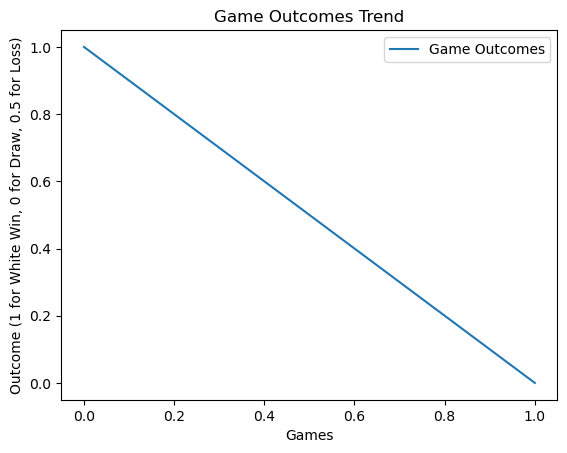

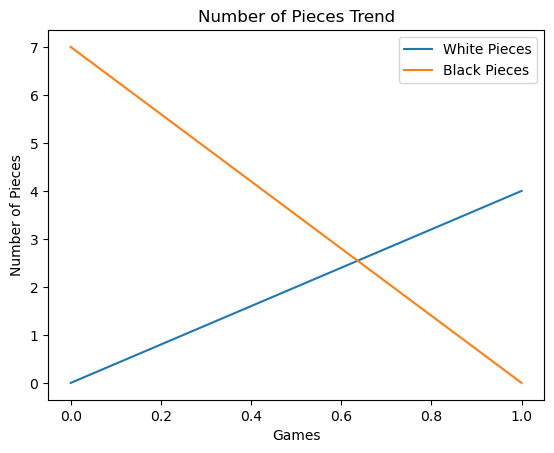

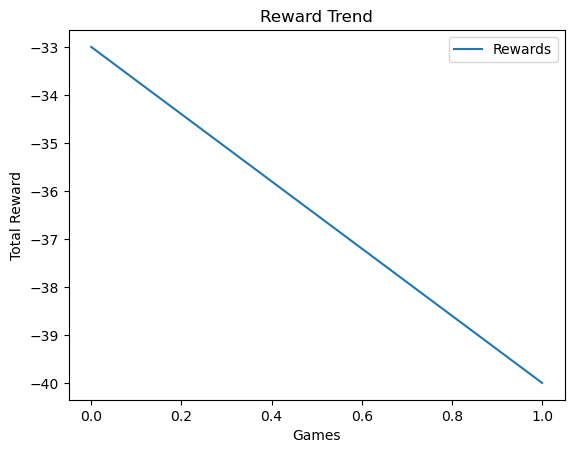

In [1]:
from collections import deque
import random
import chess
import chess.variant
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from IPython.display import display, HTML
import chess.svg
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tqdm import tqdm
from tensorflow.keras.models import Model
import chess.pgn
import numpy as np
from tensorflow.keras.models import load_model

#chess Variant Antichess



def board_to_input_array(board):
    board_array = np.zeros((8, 8, 12), dtype=np.uint8)
    piece_mapping = {'r': 0, 'n': 1, 'b': 2, 'q': 3, 'k': 4, 'p': 5, 'R': 6, 'N': 7, 'B': 8, 'Q': 9, 'K': 10, 'P': 11}
    #normalize piece values

    
    for square, piece in board.piece_map().items():
        piece_type = piece_mapping[piece.symbol()]
        color = int(piece.color)
        board_array[square // 8, square % 8, piece_type] = color + 1  # Use 0 for empty squares

    return board_array


def state_to_index(board):
    board_array = np.array(board_to_input_array(board))
    return hash(board_array.tostring()) % state_space_size[0]



def choose_action(board,model):
    if np.random.rand() < exploration_prob:
        return np.random.choice(list(board.legal_moves))
    else:
        state_index = state_to_index(board)
        legal_moves_list = list(board.legal_moves)
        if not legal_moves_list:
            return chess.Move.null()
        q_values = model.predict(np.array([board_to_input_array(board)]))[0]
        best_move_index = np.argmax(q_values)
        best_move_uci = legal_moves_list[min(best_move_index, len(legal_moves_list)-1)].uci()
        return chess.Move.from_uci(best_move_uci)
    
# Function to convert a move into an output array
def move_to_output_array(move, legal_moves):
    output_array = np.zeros(action_space_size)
    move_index = list(legal_moves).index(move)
    output_array[move_index] = 1
    return output_array



# Hyperparameters
learning_rate = 0.01
discount_factor = 0.99
exploration_prob = 0.2

# Neural Network Architecture
state_space_size = (8, 8, 12)  # 8x8 board with 12 channels (one for each piece type and color)
action_space_size = 4096



# Initialize a deque for experience replay
experience_replay_buffer = deque(maxlen=10000)

# Neural Network Model alpha zero


# Input layer
input_layer = Input(shape=state_space_size)

# Contracting path
# Convolutional layers
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
flatten_layer = Flatten()(conv2)
dense1 = Dense(64, activation='relu')(flatten_layer)
dense2 = Dense(64, activation='relu')(dense1)
output_layer = Dense(action_space_size, activation='softmax')(dense2)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1), loss=['categorical_crossentropy'], metrics=['accuracy'])


def count_pieces_by_color(board, color):
    piece_types = [chess.PAWN, chess.KNIGHT, chess.BISHOP, chess.ROOK, chess.QUEEN, chess.KING]
    return sum(len(board.pieces(piece_type, color)) for piece_type in piece_types)







def normalize_input(board):
    board_array = np.array(board_to_input_array(board), dtype=np.float16)
    board_array /= 12.0  # Assuming the maximum piece type value is 12
    return board_array



def update_q_table(state, action, reward, next_state):
    state_index = state_to_index(state)
    next_state_index = state_to_index(next_state)
    action_index = list(state.legal_moves).index(action)
    


    # Combine the rewards with weights (you can adjust the weights as needed)
    #total_reward = reward + 0.01 * piece_coordination_reward_value
    total_reward = reward

    # Store the experience in the replay buffer
    experience_replay_buffer.append((state_index, action_index, total_reward, next_state_index))

    # Sample a batch from the replay buffer for training
    batch_size = min(len(experience_replay_buffer), 8)
    if batch_size > 0:
        batch = np.array(random.sample(experience_replay_buffer, batch_size))
        states = np.array([board_to_input_array(chess.Board(fen=chess.STARTING_FEN)) for _ in batch[:, 0]])
        next_states = np.array([board_to_input_array(chess.Board(fen=chess.STARTING_FEN)) for _ in batch[:, 3]])
        q_values = model.predict(states)
        next_q_values = model.predict(next_states)
        
        for i in range(batch_size):
            action_idx = int(batch[i, 1])  # Cast to integer
            q_values[i, action_idx] += learning_rate * (
                batch[i, 2] + discount_factor * np.max(next_q_values[i]) - q_values[i, action_idx]
            )
        
        # Train the model on the batch
        model.train_on_batch(states, q_values)


def display_chess_board(board):
    return display(HTML(chess.svg.board(board=board, size=200)))

def play_game():
    board = chess.variant.GiveawayBoard()
    
    game_states = []
    total_reward = 0

    while not board.is_game_over():
        state = board.copy()
        game_states.append(state.copy())

        # Player 1 (White) makes a move
        white_move = choose_action(board, model)
        if white_move in board.legal_moves:
            board.push(white_move)
        else:
            print("Invalid move by White. Try again.")
            continue

        # Update state and check for game end
        if board.is_game_over():
            break

        # Player 2 (Black) makes a move
        black_move = choose_action(board, model)
        if black_move in board.legal_moves:
            board.push(black_move)
        else:
            print("Invalid move by Black. Try again.")
            continue

        next_state = board.copy()

        # Calculate rewards and update Q-table
        reward = calculate_reward(board) # You need to define this function based on your reward strategy
        update_q_table(state, white_move, reward, next_state)

        # Accumulate the reward
        total_reward += reward

        # Next state becomes the current state for the next iteration
        state = next_state

    game_states.append(board.copy())
    return game_states, board.result(), total_reward

    


def calculate_reward(board):
    reward = 0

    # Reward for losing pieces
    piece_count = len(board.piece_map())
    reward -= (32 - piece_count) * 0.1  # Assuming a standard 32-piece setup


    if board.is_stalemate() or board.is_insufficient_material():
        # Penalize for drawing the game
        reward -= 5
    elif board.is_fivefold_repetition() or board.is_seventyfive_moves():
        # Penalize for other types of draws
        reward -= 5

    return reward




log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
num_games = 2
total_rewards = []
results = {"white_wins": 0, "black_wins": 0, "draws": 0}
outcomes = []
num_off_white_pieces = []
num_off_black_pieces = []

reward_trend = []

for episode in tqdm(range(num_games), desc="Training"):
    exploration_prob *= 0.99  # Decay exploration probability
    print("Game:", episode)
    game_states, result, total_reward = play_game()

    # Append the total reward to the reward trend list
    reward_trend.append(total_reward)

    # Update results based on the game outcome
    if result == "1-0":
        results["white_wins"] += 1
        outcomes.append(1)
    elif result == "0-1":
        results["black_wins"] += 1
        outcomes.append(0)
    elif result == "1/2-1/2":
        results["draws"] += 1
        outcomes.append(0.5)  # Fix here: Append 0.5 for draws

    total_rewards.append(total_reward)
    
    # Usage
    white_pieces = count_pieces_by_color(game_states[-1], chess.WHITE)
    black_pieces = count_pieces_by_color(game_states[-1], chess.BLACK)
    
    num_off_white_pieces.append(white_pieces)
    num_off_black_pieces.append(black_pieces)
    
    # Display the total reward for each game
    print("Total Reward for Game {}: {}".format(episode, total_reward))
    print("Game Outcome:", result)
    #game length
    print("Game Length:", len(game_states))

# Display statistics
average_reward = sum(total_rewards) / num_games
print("Average Total Reward:", average_reward)

# Extract the FEN of the final position
final_position_fen = game_states[-1].fen()
print("Final Position FEN:", final_position_fen)

# Display the last game
for state in game_states:
    display_chess_board(state)

# Display results
print("\nResults Summary:")
print("White Wins:", results["white_wins"])
print("Black Wins:", results["black_wins"])
print("Draws:", results["draws"])

# Plot trend lines
plt.plot(outcomes, label="Game Outcomes")
plt.xlabel("Games")
plt.ylabel("Outcome (1 for White Win, 0 for Draw, 0.5 for Loss)")
plt.legend()
plt.title("Game Outcomes Trend")

plt.figure()
plt.plot(num_off_white_pieces, label="White Pieces")
plt.plot(num_off_black_pieces, label="Black Pieces")
plt.xlabel("Games")
plt.ylabel("Number of Pieces")
plt.legend()
plt.title("Number of Pieces Trend")

# Plot rewards
plt.figure()
plt.plot(reward_trend, label="Rewards")
plt.xlabel("Games")
plt.ylabel("Total Reward")
plt.legend()
plt.title("Reward Trend")

plt.show()

# Save the model

#model.save("v1_1k.h5")  # Change the file name as needed